In [1]:
import sys

sys.path.append("../competitors/swotted/")
sys.path.append("..")

from torch.utils.data import DataLoader
from model.fastswotted import fastSWoTTeDModule, fastSWoTTeDTrainer, fastSWoTTeDDataset
from model.loss_metrics import *
from experiments.gen_data import gen_synthetic_data

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

from tensorflow.python.summary.summary_iterator import summary_iterator
from glob import glob
import os

# require tensorflow (pip install tensorflow ... not installed in poetry!)

from tensorflow.python.summary.summary_iterator import summary_iterator
from glob import glob
import pandas as pd

torch.set_default_dtype(torch.float64)


2023-08-23 19:51:46.661885: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 19:51:46.663352: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 19:51:46.695008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 19:51:46.695604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 19:51:47.228516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
K = 400  #: number of patients
N = 10  #: number of medical events
T = 10  #: length of time's stay
R = 4  #: number of phenotypes
Tw = 3  #: length of time's window

# Generating synthetic data
W_, Ph_, X, params = gen_synthetic_data(
    K, N, T, R, Tw, sliding_window=True, noise=False, truncate=True
)

# create a 3D-tensor required by FastSwotted
X = torch.stack(X, dim=0)

In [3]:
params = {}
params["model"] = {}
params["model"]["non_succession"] = 10
params["model"]["sparsity"] = 10
params["model"]["rank"] = R
params["model"]["twl"] = Tw
params["model"]["N"] = N
params["model"]["metric"] = "Bernoulli"
params["training"] = {}
params["training"]["batch_size"] = 50
params["training"]["nepochs"] = 200
params["training"]["lr"] = 1e-2
params["predict"] = {}
params["predict"]["nepochs"] = 100
params["predict"]["lr"] = 1e-2

config = OmegaConf.create(params)

# define the model
swotted = fastSWoTTeDModule(config)

train_loader = DataLoader(
    fastSWoTTeDDataset(X),
    batch_size=params["training"]["batch_size"],
    shuffle=False,
    collate_fn=lambda x: x,
)


In [4]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = fastSWoTTeDTrainer(
    fast_dev_run=False, max_epochs=params["training"]["nepochs"]
)
trainer.fit(model=swotted, train_dataloaders=train_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tguyet/.cache/pypoetry/virtualenvs/swotted-experiments-S0t91BvZ-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type              | Params
--------------------------------------------
0 | model | SlidingWindowConv | 0     
--------------------------------------------
120       Trainable params
0         Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
/home/tguyet/.cache/pypoetry/virtualenvs/swotted-experiments-S0t91BvZ-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottlene

Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 147.35it/s, v_num=502]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 137.50it/s, v_num=502]


In [5]:
# get the last logs
l=glob("lightning_logs/version_*/events.out.tfevents.*")
l.sort(key=os.path.getmtime)
event_file = l[-1]

data={"train_reconstr_Ph":[],
      "train_sparsity_Ph":[],
      "train_loss_Ph":[],
      "train_reconstr_W":[],
      "train_nonsucc_W":[],
      "train_loss_W":[],
      "epoch":[]}

epoch=1
for e in summary_iterator(event_file):
    #print("-------")
    for v in e.summary.value:
        if v.tag=="epoch": continue
        try:
            data[v.tag].append(v.simple_value)
        except:
            None
        if v.tag=="train_loss_W":
            data["epoch"].append(epoch)
    epoch += 1

data=pd.DataFrame(data)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
for k,v in data.items():
    print( k, len(v))

train_reconstr_Ph 32
train_sparsity_Ph 32
train_loss_Ph 32
train_reconstr_W 32
train_nonsucc_W 32
train_loss_W 32
epoch 32


In [7]:
data.iloc[-1]

train_reconstr_Ph    592.564880
train_sparsity_Ph      8.002261
train_loss_Ph        672.587524
train_reconstr_W     592.546387
train_nonsucc_W        2.542147
train_loss_W         617.967834
epoch                224.000000
Name: 31, dtype: float64

<Axes: >

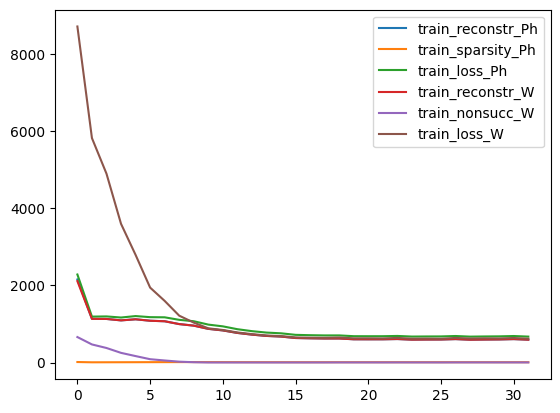

In [8]:
data[["train_reconstr_Ph",
      "train_sparsity_Ph",
      "train_loss_Ph",
      "train_reconstr_W",
      "train_nonsucc_W",
      "train_loss_W"]].plot.line()

In [9]:
from model.swotted import swottedModule, swottedTrainer
from model.utils import Subset

In [10]:
swotted = swottedModule(config)

train_loader = DataLoader(
    Subset(X, np.arange(len(X))),
    batch_size=params["training"]["batch_size"],
    shuffle=False,
    collate_fn=lambda x: x,
)

In [11]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = swottedTrainer(
    fast_dev_run=False, max_epochs=params["training"]["nepochs"]
)
trainer.fit(model=swotted, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/tguyet/.cache/pypoetry/virtualenvs/swotted-experiments-S0t91BvZ-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type          | Params
----------------------------------------
0 | model | SlidingWindow | 0     
----------------------------------------
120       Trainable params
0         Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
/home/tguyet/.cache/pypoetry/virtualenvs/swotted-experiments-S0t91BvZ-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performanc

Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 14.65it/s, v_num=503]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 13.37it/s, v_num=503]


In [12]:
# get the last logs
l=glob("lightning_logs/version_*/events.out.tfevents.*")
l.sort(key=os.path.getmtime)
event_file = l[-1]

data={"train_reconstr_Ph":[],
      "train_sparsity_Ph":[],
      "train_loss_Ph":[],
      "train_reconstr_W":[],
      "train_nonsucc_W":[],
      "train_loss_W":[],
      "epoch":[]}

epoch=1
for e in summary_iterator(event_file):
    #print("-------")
    for v in e.summary.value:
        if v.tag=="epoch": continue
        try:
            data[v.tag].append(v.simple_value)
        except:
            None
        if v.tag=="train_loss_W":
            data["epoch"].append(epoch)
    epoch += 1

data=pd.DataFrame(data)

In [13]:
for k,v in data.items():
    print( k, len(v))

train_reconstr_Ph 32
train_sparsity_Ph 32
train_loss_Ph 32
train_reconstr_W 32
train_nonsucc_W 32
train_loss_W 32
epoch 32


<Axes: >

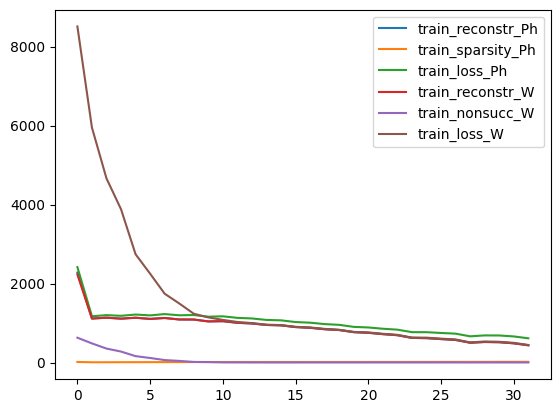

In [14]:
data[["train_reconstr_Ph",
      "train_sparsity_Ph",
      "train_loss_Ph",
      "train_reconstr_W",
      "train_nonsucc_W",
      "train_loss_W"]].plot.line()